In [1]:
import matplotlib.pyplot as plt
import numpy as np
import _pickle as pickle
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta

# Helper functions

In [5]:
def compute_coverage_len(y_test, y_lower, y_upper):
    """ 
    Compute average coverage and length of prediction intervals
    """
    in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
    coverage = in_the_range / (y_test.shape[0]*y_test.shape[1])
    avg_length = np.mean(abs(y_upper - y_lower))
    avg_length = avg_length/(y_test.max()-y_test.min())
    print("PI coverage:",coverage,",PI avg. length",avg_length)
    return coverage, avg_length


def asym_nonconformity(label,low,high):
    """
    Compute the asymetric conformity score
    
    credit - https://github.com/yromano/cqr
    """
    y_lower = low
    y_upper = high
    error_high = label - y_upper 
    error_low = y_lower - label
    return error_low, error_high


def transform_to_windows(data_org, station):
    """
    Create dataframe with hours as columns 

    credit - https://github.com/nicholasjhana/short-term-energy-demand-forecasting
    """
    #from the original datetime index create new columns with each of the year, month, day, and hour.
    data = data_org.copy()
    data.loc[:,'year'] = data.index.year
    data.loc[:,'month'] = data.index.month
    data.loc[:,'day'] = data.index.day
    data.loc[:,'hours'] = data.index.hour
    #construct datetimes from the split year, month, day columns
    data.loc[:,'date'] = pd.to_datetime(data.loc[:,['year', 'month', 'day']], format='%Y-%m-%d', errors='ignore')
    #set the index to dates only
    data = data.set_index(pd.DatetimeIndex(data['date']))
    #drop non target columns 
    data = data.loc[:,[station, 'hours']]
    #pivot the table into the format Date h0, h1, ...h23
    data = data.pivot(columns='hours', values=station)
    data = data.dropna()
    return data


def split_sequences(sequences, n_steps):
    """
    Split data into observations and labels 

    credit - https://github.com/nicholasjhana/short-term-energy-demand-forecasting
    """
    max_step=n_steps
    n_steps+=1
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + max_step
        #create a list with the indexes we want to include in each sample
        slices = [x for x in range(end_ix-1,end_ix-n_steps, -1)] + [y for y in range(end_ix-n_steps, i, -7)]
        #reverse the slice indexes
        slices = list(reversed(slices))
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequences[slices, :]
        seq_y = sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    X = np.array(X)
    X = np.reshape(X,(X.shape[0],X.shape[1]*X.shape[2],1))
    y = np.array(y)
    return X, y


def create_datasets(data):
    """
    Create input-output pairs from a dataframe with observations
    """
    df_data=[]
    cols = data.columns
    for i,s in enumerate(cols): 
        if i == 0:
            X,Y = split_sequences(transform_to_windows(data,s).values,7)
            X = X.reshape((X.shape[0],X.shape[1]*X.shape[-1]))
        else:
            x,y = split_sequences(transform_to_windows(data,s).values,7)
            x =x.reshape((x.shape[0],x.shape[1]*x.shape[-1]))
            X = np.append(X,x,-1)
    return X,Y


def create_ensemble_datasets(df_train, B):
    """
    Create independent ensemble subsets - subsampling 

    df_train = dataframe with training data
    B = number of ensemble models 
    """
    train = []
    train_ensemble=[]
    cols = df_train.columns
    for j,s in enumerate(cols):
        df_v_t = transform_to_windows(df_train,s)
        train_s = []
        for i in range(B):
            sb_size = int(np.floor(len(df_v_t)/B))
            X,Y = split_sequences(df_v_t[i*sb_size:i*sb_size+sb_size].values,7)
            train_s.append([X,Y])
        train_ensemble.append(train_s)
  
    # combine all features 
    for j in range(B):
        for i,s in enumerate(cols):
            if i == 0:
                etrain_x, etrain_y= train_ensemble[i][j]
                etrain_x = etrain_x.reshape((etrain_x.shape[0],etrain_x.shape[1]*etrain_x.shape[-1]))
            else:
                etrain_xx, etrain_yy = train_ensemble[i][j]
                etrain_xx = etrain_xx.reshape((etrain_xx.shape[0],etrain_xx.shape[1]*etrain_xx.shape[-1]))
                etrain_x = np.append(etrain_x,etrain_xx,axis=-1)
        train.append([etrain_x,etrain_y])
    return train


# Dataset

Import Solar dataset from https://github.com/Duvey314/austin-green-energy-predictor

In [6]:
url = 'https://raw.githubusercontent.com/Duvey314/austin-green-energy-predictor/master/Resources/Output/Webberville_Solar_2017-2020_MWH.csv'
df = pd.read_csv(url)
df = df.drop(columns=('Weather_Description'))
df = df.drop(columns=('Year'))
df = df.drop(columns=('Month'))
df = df.drop(columns=('Day'))
df = df.drop(columns=('Hour'))
df = df.drop(columns=('Date_Time'))

# create date+hour index 
date_list = pd.date_range(start='01/01/2017', end='31/07/2020')
date_list = pd.to_datetime(date_list)
hour_list = []
for nDate in date_list:
    for nHour in range(24):
        tmp_timestamp = nDate+timedelta(hours=nHour)
        hour_list.append(tmp_timestamp)
date_list = pd.to_datetime(hour_list) 

df['hour_list'] = date_list[:-1]
df = df.set_index('hour_list')

# train, val, test datasets
df_train = df[0:365*24]
df_val = df[365*24:365*24*2]
df_test = df[365*24*2:365*24*3]

# split into input-output pairs
train_x, train_y = create_datasets(df_train)
val_x, val_y = create_datasets(df_val)
test_x, test_y = create_datasets(df_test)

# create ensemble subsets - subsamping
df_ensemble = create_ensemble_datasets(df_train,B=3)

# Quantile Random Forest (QRF)

Build prediction intervals using quantile regression.

PI coverage: 0.8692970204841713 ,PI avg. length 0.25306891252652386


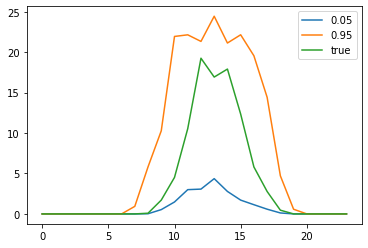

In [7]:
def quantile_RF(train_x, train_y, test_x, n_trees = 10, percentile=90):
  model = RandomForestRegressor(n_estimators=n_trees)
  model.fit(train_x, train_y) 
  prediction_int = np.zeros((test_x.shape[0],24,3))
  preds = []
  for tree in model.estimators_:
        preds.append(tree.predict(test_x))
  for i in range(test_x.shape[0]):
    for j in range(24):
      single_pred= []
      for d in range(len(model.estimators_)):
        single_pred.append(preds[d][i,j])
      prediction_int[i,j,0] = np.percentile(single_pred, (100 - percentile) / 2.)
      prediction_int[i,j,1] = np.percentile(single_pred,50)
      prediction_int[i,j,-1] = np.percentile(single_pred, 100 - (100 - percentile) / 2.)
  return prediction_int

pred = quantile_RF(train_x,train_y,test_x)
c,l = compute_coverage_len(test_y,pred[:,:,0],pred[:,:,-1])

plt.plot(pred[0,:,0],label='0.05')
plt.plot(pred[0,:,-1],label='0.95')
plt.plot(test_y[0,:],label='true')
plt.legend()
plt.show()

# EnbPI QRF

Build prediction intervals using the EnbPI algorithm (http://proceedings.mlr.press/v139/xu21h.html).

PI coverage: 0.9054934823091247 ,PI avg. length 0.6324390083773399


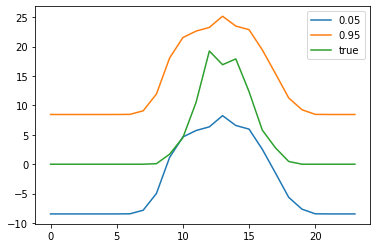

In [8]:
def fit_enbpi_bootstrap_models(train, testX, testY, B, index, alpha):
  """ fit B TCN models on B bootstrap datasets created from train data
  Parameters
  ----------
  trainX - training obs.
  trainY - training labels
  B      - no. bootstrap models 

  Returns
  -------
  f_hat_b_agg     - aggregated leave-one-out predictions for Sb
  ensemble_models - trained models
  """
  f_hat_b_agg = np.zeros((train[index[0]][0].shape[0],24,B))
  ensemble_models = []

  dct = {}    # dict containing LOO predictions
  for key in index:
    dct['pred_%s' % key] = []
  
  for b in range(B):    # training a model for each sub set Sb
    rf = RandomForestRegressor(n_estimators=10)
    rf.fit(train[b][0], train[b][1])
    ensemble_models.append(rf)
    # Leave-one-out predictions for each Sb
    train_LOO = []
    indx_LOO = index[np.arange(len(index))!=b]
    for i in range(len(indx_LOO)):
      dct['pred_%s' %indx_LOO[i]].append(rf.predict(train[indx_LOO[i]][0]))
  for b in range(B):
    f_hat_b_agg[:,:,b] = np.mean(dct['pred_%s' %b],axis=0) # aggregate predictions
   
  epsilon = []    # absolute residuals
  for j in range(B):
    trainY_inv = train[j][1]
    for i in range(trainY_inv.shape[0]):
      epsilon.append(abs(trainY_inv[i,:]-f_hat_b_agg[i,:,j]))
  epsilon = np.ndarray.flatten(np.array(epsilon))
  
  f_hat_t = np.zeros((testX.shape[0],testY.shape[1],B))   # predict test data using B models
  for b,model in enumerate(ensemble_models):
      f_hat_t[:,:,b] = model.predict(testX)
  
  prediction_interval = np.zeros((testY.shape[0],testY.shape[1],3))
  f_hat_t_agg = np.zeros((testY.shape[0],testY.shape[1]))
  for day in range(testY.shape[0]):
    f_hat_t_agg[day,:] = np.mean(f_hat_t[day,:,:],axis=-1) # aggregate all B predictions 
    for hour in range(testY.shape[1]):
      ind_q = (np.ceil((1-alpha)*(len(epsilon)+1))).astype(int)
      f_quantile = np.mean(f_hat_t[day,hour,:])
      e_quantile = np.sort(epsilon)[ind_q]
      prediction_interval[day,hour,0] = f_quantile - e_quantile
      prediction_interval[day,hour,1] = f_quantile
      prediction_interval[day,hour,-1] = f_quantile + e_quantile

    # update epsilon (s = 24) - TO DO: add s an an input variable
    e_j = abs(testY[day,:]-f_hat_t_agg[day,:])
    epsilon = np.delete(epsilon,slice(0,24,1))
    epsilon = np.append(epsilon,e_j)
  return prediction_interval

pred = fit_enbpi_bootstrap_models(df_ensemble, test_x, test_y, 3, np.array([0,1,2]), 0.10)
c,l = compute_coverage_len(test_y,pred[:,:,0],pred[:,:,-1])

plt.plot(pred[0,:,0],label='0.05')
plt.plot(pred[0,:,-1],label='0.95')
plt.plot(test_y[0,:],label='true')
plt.legend()
plt.show()

# EnCQR QRF

Build prediction intervals using the proposed *Ensemble Conformalized Quantile Regression*.

PI coverage: 0.9146880819366853 ,PI avg. length 0.3294170414062304


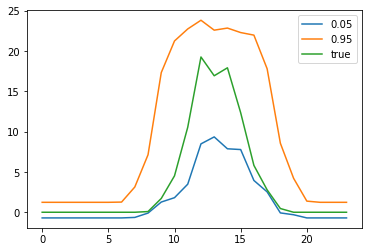

In [10]:
def pred_ints(model, X, percentile=90):
    err_down = np.zeros((X.shape[0],24))
    err_up = np.zeros((X.shape[0],24))
    err = np.zeros((X.shape[0],24))

    preds = []
    for tree in model.estimators_:
          preds.append(tree.predict(X))
    for i in range(X.shape[0]):
      for j in range(24):
        single_pred= []
        for d in range(len(model.estimators_)):
          single_pred.append(preds[d][i,j])
        err_down[i,j] = np.percentile(single_pred, (100 - percentile) / 2.)
        err[i,j] = np.percentile(single_pred, 50)
        err_up[i,j] = np.percentile(single_pred, 100 - (100 - percentile) / 2.)
    return err_down, err, err_up

def fit_EnCQR_models(train, testX, testY, B, index, alpha):
  """ fit B TCN models on B subsets created from train data
  Parameters
  ----------
  trainX - training obs.
  trainY - training labels
  B      - no. ensemble models 

  Returns
  -------
  f_hat_b_agg     - aggregated leave-one-out predictions for Sb
  ensemble_models - trained models
  indx            - array of Sb indices
  """
  f_hat_b_agg_low = np.zeros((len(train[index[0]][0]),24,B))
  f_hat_b_agg_mean = np.zeros((len(train[index[0]][0]),24,B))
  f_hat_b_agg_high = np.zeros((len(train[index[0]][0]),24,B))
  ensemble_models = []

  # dict containing LOO predictions
  dct_lo = {}
  dct_mean = {}
  dct_hi = {}
  for key in index:
    dct_lo['pred_%s' % key] = []
    dct_mean['pred_%s' % key] = []
    dct_hi['pred_%s' % key] = []

  # training a model for each sub set Sb
  for b in range(B):
    rf = RandomForestRegressor(n_estimators=10)
    rf.fit(train[b][0], train[b][1])
    ensemble_models.append(rf)
    # Leave-one-out predictions for each Sb
    indx_LOO = index[np.arange(len(index))!=b]
    for i in range(len(indx_LOO)):
        pred = rf.predict(train[indx_LOO[i]][0])
        err_down, err, err_up = pred_ints(rf, train[indx_LOO[i]][0], percentile=90)
        dct_lo['pred_%s' %indx_LOO[i]].append(err_down)
        dct_mean['pred_%s' %indx_LOO[i]].append(err)
        dct_hi['pred_%s' %indx_LOO[i]].append(err_up)
  for b in range(B):
    f_hat_b_agg_low[:,:,b] = np.mean(dct_lo['pred_%s' %b],axis=0) 
    f_hat_b_agg_mean[:,:,b] = np.mean(dct_mean['pred_%s' %b],axis=0) 
    f_hat_b_agg_high[:,:,b] = np.mean(dct_hi['pred_%s' %b],axis=0)  

  # residuals
  epsilon = []
  epsilon_hi=[]
  for j in range(B):
    trainY_inv = train[j][1]
    # for each day in train Y 
    for i in range(trainY_inv.shape[0]):
      e_low,e_high = asym_nonconformity(label=trainY_inv[i,:],low=f_hat_b_agg_low[i,:,j],high=f_hat_b_agg_high[i,:,j])
      epsilon.append(e_low)
      epsilon_hi.append(e_high)
  epsilon = np.ndarray.flatten(np.array(epsilon))
  epsilon_hi = np.ndarray.flatten(np.array(epsilon_hi))

  # predict test data
  f_hat_t_low = np.zeros((testX.shape[0],testY.shape[1],B))
  f_hat_t_mean = np.zeros((testX.shape[0],testY.shape[1],B))
  f_hat_t_high = np.zeros((testX.shape[0],testY.shape[1],B))
  for b,model in enumerate(ensemble_models):
   f_hat_t_low[:,:,b], f_hat_t_mean[:,:,b], f_hat_t_high[:,:,b] = pred_ints(model, testX, percentile=90)

  # construct PI
  prediction_interval = np.zeros((testY.shape[0],testY.shape[1],3))
  f_hat_t_agg_low = np.zeros((testY.shape[0],testY.shape[1]))
  f_hat_t_agg_mean = np.zeros((testY.shape[0],testY.shape[1]))
  f_hat_t_agg_hi = np.zeros((testY.shape[0],testY.shape[1]))
  org_prediction_interval = np.zeros((testY.shape[0],testY.shape[1],3))

  
  for day in range(testY.shape[0]):   # aggregate all B predictions for test data
    f_hat_t_agg_low[day,:] = np.mean(f_hat_t_low[day,:,:],axis=-1)
    f_hat_t_agg_mean[day,:] = np.mean(f_hat_t_mean[day,:,:],axis=-1)
    f_hat_t_agg_hi[day,:] = np.mean(f_hat_t_high[day,:,:],axis=-1)

    for hour in range(testY.shape[1]):
      # asymetric conformity score index
      index = int(np.ceil((1 - alpha / 2) * (len(epsilon) + 1))) - 1
      index = min(max(index, 0), len(epsilon) - 1)

      # aggregate predictions
      f_quantile_low = np.mean(f_hat_t_low[day,hour,:])
      f_quantile_mean = np.mean(f_hat_t_mean[day,hour,:])
      f_quantile_high = np.mean(f_hat_t_high[day,hour,:])

      # original PI, before conformalization 
      org_prediction_interval[day,hour,0],org_prediction_interval[day,hour,1],org_prediction_interval[day,hour,-1] = f_quantile_low,f_quantile_mean,f_quantile_high

      # conformalization
      e_quantile_lo = np.sort(epsilon)
      e_quantile_hi = np.sort(epsilon_hi)
      e_quantile_lo = e_quantile_lo[index]
      e_quantile_hi = e_quantile_hi[index]  
      prediction_interval[day,hour,0] = f_quantile_low - e_quantile_lo
      prediction_interval[day,hour,1] = f_quantile_mean
      prediction_interval[day,hour,-1] = f_quantile_high + e_quantile_hi

    # update epsilon (s = 24) - TO DO: include s as an input variable
    e_lo,e_hi = asym_nonconformity(label=testY[day,:],low=f_hat_t_agg_low[day,:],high=f_hat_t_agg_hi[day,:])
    epsilon = np.delete(epsilon,slice(0,24,1))
    epsilon_hi = np.delete(epsilon_hi,slice(0,24,1))
    epsilon = np.append(epsilon,e_lo)
    epsilon_hi = np.append(epsilon_hi,e_hi)
  return prediction_interval

pred = fit_EnCQR_models(df_ensemble, test_x, test_y, 3, np.array([0,1,2]), 0.10)
c,l = compute_coverage_len(test_y,pred[:,:,0],pred[:,:,-1])
plt.plot(pred[0,:,0],label='0.05')
plt.plot(pred[0,:,-1],label='0.95')
plt.plot(test_y[0,:],label='true')
plt.legend()
plt.show()